C:\Users\aikid\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


Failed to read file with encoding: utf-8
Failed to read file with encoding: utf-8-sig
File read successfully with encoding: cp1252
Edgap (7986, 7)
CCD (102181, 23)
Edgap columns:
['NCESSCH School ID', 'CT Unemployment Rate', 'CT Pct Adults with College Degree', 'CT Pct Childre In Married Couple Family', 'CT Median Household Income', 'School ACT average (or equivalent if SAT score)', 'School Pct Free and Reduced Lunch']

CCD columns:
['SCHOOL_YEAR', 'STATENAME', 'ST', 'SCH_NAME', 'LEA_NAME', 'ST_LEAID', 'LEAID', 'ST_SCHID', 'NCESSCH', 'SCHID', 'MSTREET1', 'MCITY', 'MSTATE', 'MZIP', 'LSTREET1', 'LCITY', 'LSTATE', 'LZIP', 'UPDATED_STATUS_TEXT', 'EFFECTIVE_DATE', 'SCH_TYPE_TEXT', 'SCH_TYPE', 'LEVEL']

Edgap dtypes: school_id                        int64
unemployment_rate              float64
pct_adults_college             float64
pct_children_married_family    float64
median_household_income        float64
act_score                      float64
pct_free_reduced_lunch         float64
dtype:

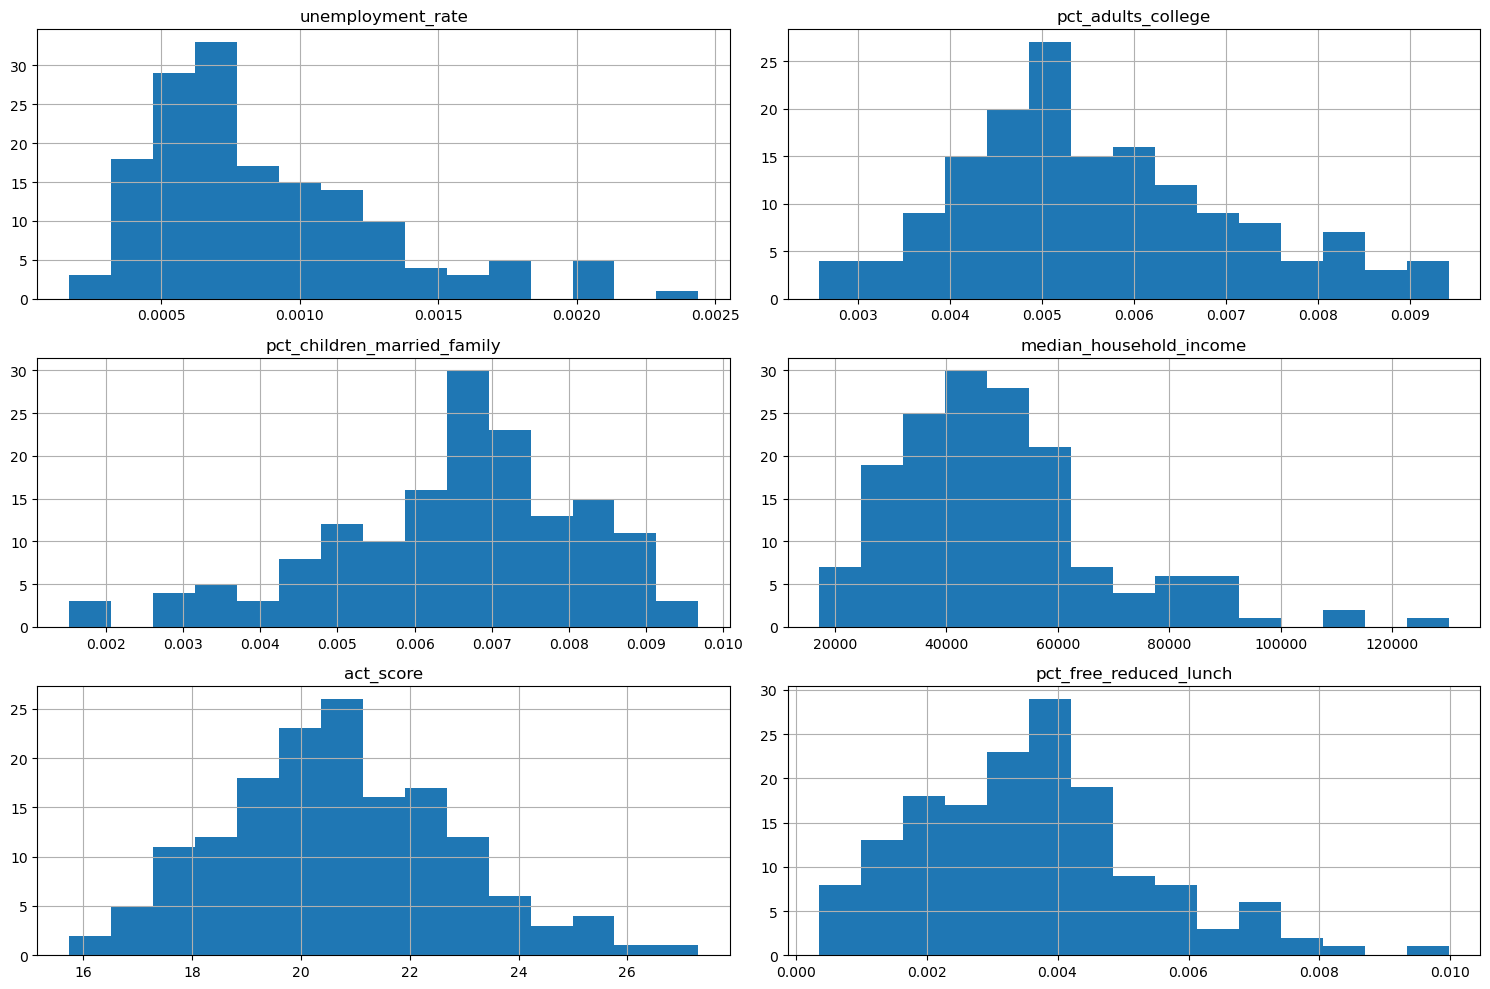


Correlation matrix:
                              unemployment_rate  pct_adults_college  \
unemployment_rate                     1.000000           -0.310673   
pct_adults_college                   -0.310673            1.000000   
pct_children_married_family          -0.462609            0.290719   
median_household_income              -0.463476            0.655904   
act_score                            -0.186899            0.628814   
pct_free_reduced_lunch                0.336591           -0.586063   

                             pct_children_married_family  \
unemployment_rate                              -0.462609   
pct_adults_college                              0.290719   
pct_children_married_family                     1.000000   
median_household_income                         0.601365   
act_score                                       0.316232   
pct_free_reduced_lunch                         -0.479842   

                             median_household_income  act_score  \

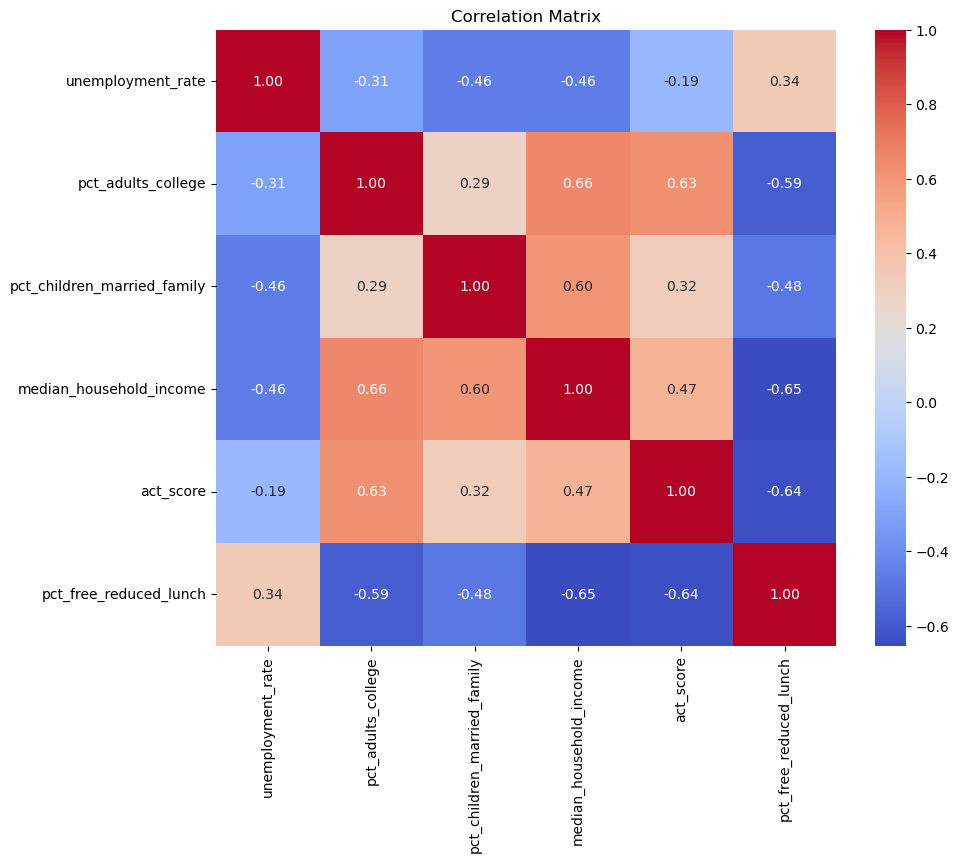

                            OLS Regression Results                            
Dep. Variable:              act_score   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     31.11
Date:                Sun, 19 Oct 2025   Prob (F-statistic):           1.24e-21
Time:                        20:58:39   Log-Likelihood:                -279.71
No. Observations:                 156   AIC:                             571.4
Df Residuals:                     150   BIC:                             589.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

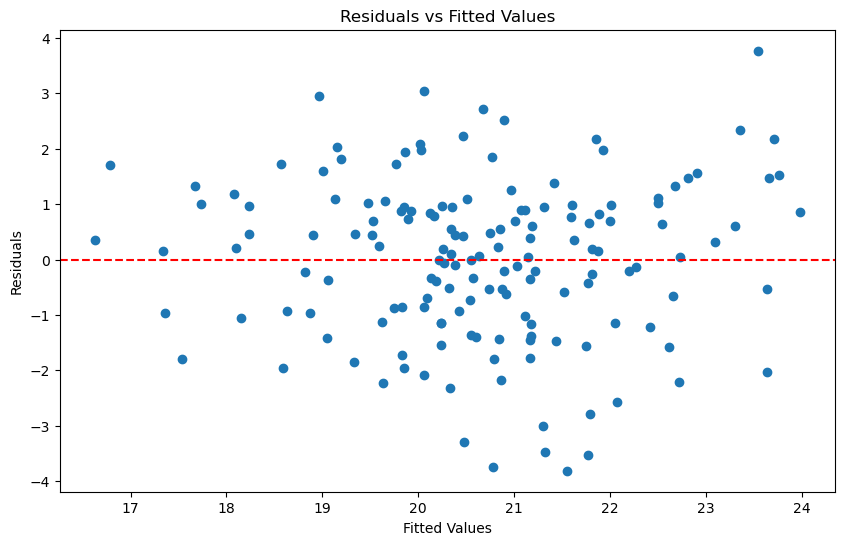

In [44]:
!pip install openpyxl
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pathlib import Path

#Set display options:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
#Read file
try:
    BASE = Path(__file__).resolve().parent   # script directory
except NameError:
    BASE= Path.cwd()   # notebook or interactive session

DATA_DIR = BASE / "Data"

#Load file
edgap= pd.read_excel(DATA_DIR/'EdGap_data.xlsx', engine='openpyxl')

for enc in ('utf-8', 'utf-8-sig','cp1252','latin1'):
    try:
        ccd= pd.read_csv(DATA_DIR/'ccd_sch_029_1617_w_1a_11212017.csv', encoding= enc, low_memory=False)
        print(f"File read successfully with encoding: {enc}")
        break
    except UnicodeDecodeError:
        print(f"Failed to read file with encoding: {enc}")
        continue
ccd= pd.read_csv(DATA_DIR/'ccd_sch_029_1617_w_1a_11212017.csv', encoding= enc, low_memory=False, on_bad_lines="warn")

print("Edgap", edgap.shape)
print('CCD', ccd.shape)
#Check for loaded data
edgap.head()
ccd.head()

# Inspect data for mismatches:
print('Edgap columns:')
print(list(edgap.columns))
print('\nCCD columns:')
print(list(ccd.columns))



#Rename columns for consistency and snake_case:
edgap.rename(columns={
    'NCESSCH School ID': 'school_id',
    'CT Unemployment Rate': 'unemployment_rate',
    'CT Pct Adults with College Degree': 'pct_adults_college',
    'CT Pct Childre In Married Couple Family': 'pct_children_married_family',
    'CT Median Household Income': 'median_household_income',
    'School ACT average (or equivalent if SAT score)': 'act_score',
    'School Pct Free and Reduced Lunch': 'pct_free_reduced_lunch'}, inplace=True)

ccd.rename(columns={
    'NCESSCH': 'school_id',
    'SCH_NAME': 'school_name',
    'STATENAME': 'state_name',
    'ST': 'state_abbr',
    'LEA_NAME': 'district_name',
    'LEVEL': 'school_level',
    'SCH_TYPE_TEXT': 'school_type',
    'SCHOOL_YEAR': 'school_year'}, inplace=True)
#Filter and keep relevant columns:
edgap = edgap[['school_id', 'unemployment_rate', 'pct_adults_college', 'pct_children_married_family', 'median_household_income', 'act_score', 'pct_free_reduced_lunch']]
ccd = ccd[['school_id', 'school_name', 'state_name', 'state_abbr', 'district_name', 'school_level', 'school_type', 'school_year']]

# Make columns consistent for merging and clean data. Also defining data types for memory efficiency.
print('\nEdgap dtypes:', edgap.dtypes)
print('\nCCD dtypes:', ccd.dtypes)

print(edgap['act_score'].dtype)
print(edgap['pct_free_reduced_lunch'].dtype)

#Convert percentages to numeric, coercing errors to NaN:
def convert_to_numeric(series):
    # Convert to string, strip whitespace, remove percent signs, commas and spaces, and handle empty strings
    s = series.astype(str).str.strip()
    # Replace empty strings with NaN (after stripping)
    s = s.replace('', np.nan)
    # Remove percent sign, commas and remaining spaces before numeric conversion
    s = s.str.replace('%', '', regex=False).str.replace(',', '', regex=False).str.replace(' ', '', regex=False)
    return pd.to_numeric(s, errors='coerce')

    
#Convert percentages for columns in edgap:
edgap['unemployment_rate'] = convert_to_numeric(edgap['unemployment_rate']) / 100
edgap['pct_adults_college'] = convert_to_numeric(edgap['pct_adults_college']) / 100
edgap['pct_children_married_family'] = convert_to_numeric(edgap['pct_children_married_family']) / 100
edgap['pct_free_reduced_lunch'] = convert_to_numeric(edgap['pct_free_reduced_lunch']) / 100
edgap['median_household_income'] = pd.to_numeric(edgap['median_household_income'].astype(str).str.replace(' ',''), errors='coerce')
edgap['act_score'] = pd.to_numeric(edgap['act_score'].astype(str).str.replace(' ',''), errors='coerce')

#Filter ACT scores to High Schools only::
ccd_high_schools = ccd[ccd['school_level'] == 'High'].copy()
print('CCD High Schools shape:', ccd_high_schools.shape)

#Remove duplicates from edgap and ccd from High Schools:
edgap.drop_duplicates(subset='school_id', inplace=True)
ccd_high_schools.drop_duplicates(subset='school_id', inplace=True)
print('Edgap shape after removing duplicates:', edgap.shape)
print('CCD High Schools shape after removing duplicates:', ccd_high_schools.shape)

#Find empty or zero ACT scores:
empty_act_scores = edgap[edgap['act_score'].isnull() | (edgap['act_score'] == 0)]
print('Number of schools with empty or zero ACT scores:', empty_act_scores.shape[0])
#Remove rows with empty or zero ACT scores:
edgap = edgap[~(edgap['act_score'].isnull() | (edgap['act_score'] == 0))]
print('Edgap shape after removing empty or zero ACT scores:', edgap.shape)

# Convert edgap school_id to 12-digit string
edgap['school_id'] = edgap['school_id'].astype(str).str[:10]

# Convert CCD school_id from float to int, then to 12-digit string
ccd_high_schools['school_id'] = (
    ccd_high_schools['school_id']
    .fillna(0)  # handle any NaNs
    .astype(int)
    .astype(str)
    .str[:10]
)
#Merge datasets on school_id and school_level:
edgap_ccd = pd.merge(edgap, ccd_high_schools, on='school_id', how='inner')
print('Merged dataset shape:', edgap_ccd.shape)
edgap_ccd.drop_duplicates(subset='school_id', inplace=True)
print('Merged dataset shape after removing duplicates:', edgap_ccd.shape)
edgap_ccd.head()

#Tidy up merged dataset and lower case snake_case column names after merge
edgap_ccd.columns = [col.lower() for col in edgap_ccd.columns]
print('Merged dataset columns:', list(edgap_ccd.columns))
print(edgap_ccd.info())


#plot histograms for numeric columns:
numeric_cols = ['unemployment_rate', 'pct_adults_college', 'pct_children_married_family', 'median_household_income', 'act_score', 'pct_free_reduced_lunch']
edgap_ccd[numeric_cols].hist(bins=15, figsize=(15, 10))
plt.tight_layout()
plt.show()  

#Correlation matrix:
correlation_matrix = edgap_ccd[numeric_cols].corr()
print('\nCorrelation matrix:\n', correlation_matrix)
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

#Linear regression model for ACT score prediction:
formula = 'act_score ~ unemployment_rate + pct_adults_college + pct_children_married_family + median_household_income + pct_free_reduced_lunch'
model = smf.ols(formula=formula, data=edgap_ccd).fit()
print(model.summary())

#Plot of residuals:
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')

plt.show()

#Export cleaned merged dataset to CSV:
edgap_ccd.to_csv(DATA_DIR/'edgap_ccd_merged_cleaned.csv', index=False)
